For each class, there is one pattern occurring in the data. Solving just a classification task be scored no higher than 70%. 

Please provide either pdf with the report or add some notes in the notebook. Demonstrate some examples of how your approach works.

A short reminder of your task:
 - Correct classification of provided time series
 - Explanation of the prediction
 - Neural network with at least one recurrent layer must be used in each step
 - Not the whole logic must be inside the neural network
 - Your approach should work for other data, of course after retraining. It means you shouldn't take advantage of knowing the series are based on sin function and how the anomalies are created.

In [201]:
%load_ext autoreload

%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px
import matplotlib.pyplot as plt
import utils
from plotnine import *
from sklearn.metrics import accuracy_score, precision_score, recall_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [202]:
np.random.seed(42)

In [203]:
n = 50000

In [204]:
def createRow(n, classes):
    # Selecting starting point as random from [0,1] we select random phase of the signal
    #By adding 10,15,7 we set frequency of the line
    base = np.sin(np.linspace((np.random.rand(3)),(np.random.rand(3) + np.array([10,15,7])),n)) 
    if classes[0] > 0:
        base[np.random.randint(0,n), 0] += 2
    if classes[1] > 0:
        base[np.random.randint(0,n), 1] -= 2
    if classes[2] > 0:
        x = np.random.randint(0,n-5)
        base[x:x+4,2] = 0
    if classes[3] > 0:
        x = np.random.randint(0,n-10)
        base[x:x+8,1] += 1.5
    if classes[4] > 0:
        x = np.random.randint(0,n-7)
        base[x:x+6,0] += 1.5
        base[x:x+6,2] -= 1.5
    base += np.random.rand(*base.shape)*.2
    return base

In [205]:
xl, yl = [], []
for _ in range(n):
    cl = np.random.rand(5)<.25
    xl.append(createRow(np.random.randint(40,60), cl))
    yl.append(cl)
    

[False False False False  True]


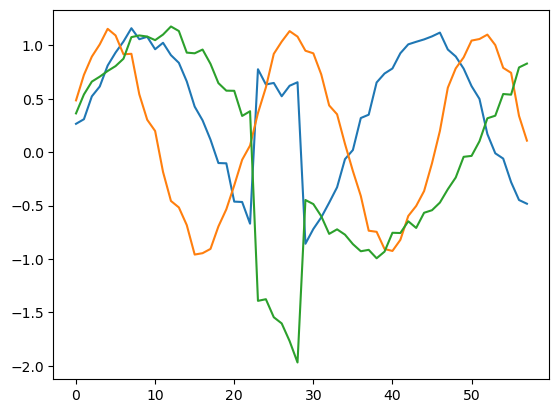

[False False False  True  True]


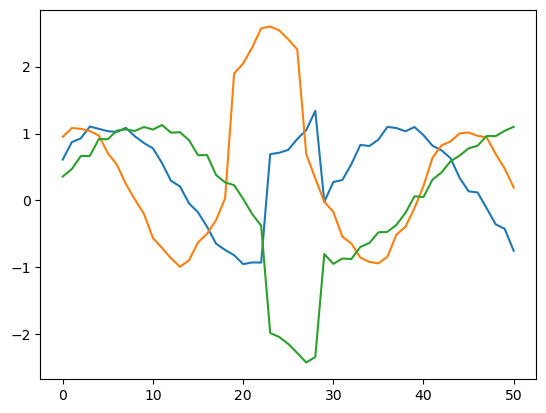

[False False False False False]


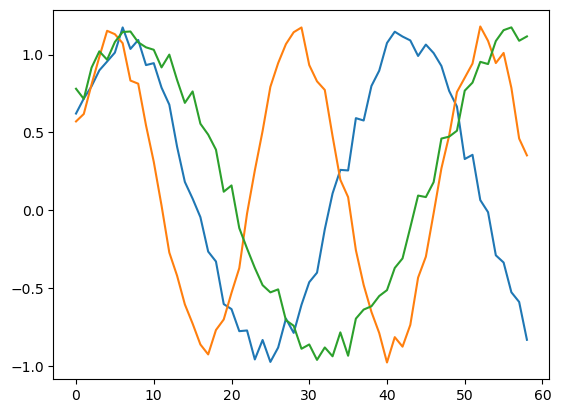

[ True False False False  True]


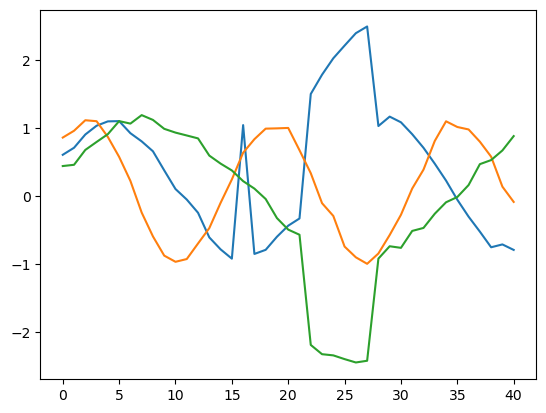

[False  True False False False]


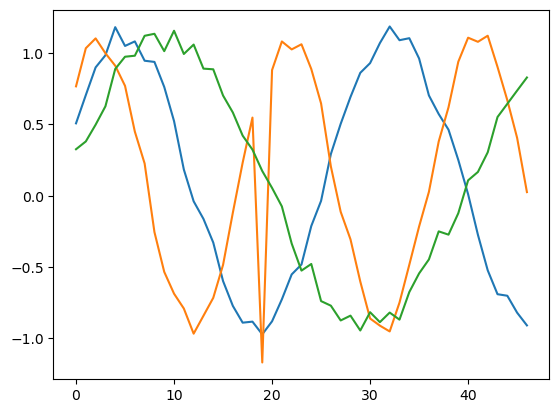

In [206]:
for i in range(5):
    plt.plot(xl[i])
    print(yl[i])
    plt.show()

#### Small analysis

Assuming I know nothing about the signal lets check at first if these all have same lengths


In [207]:
type(xl), xl[0].shape, xl[1].shape #Clearly shapes don't match, we have 3 signals but their shapes differ

(list, (58, 3), (51, 3))

Lets see some statistics of these signal lengths. So signals are in range [40:60) and their length is uniformly distributed. <br>
So we can either pad all of them to match 60 once, or we can pad them dynamically. But since distribution is uniform and we have only 20 these values. For batch size like 512 we will end up padding them to 60 anyways. So we will pad them once

0,25,50,75, 100 quantiles: [40. 44. 49. 55. 59.]


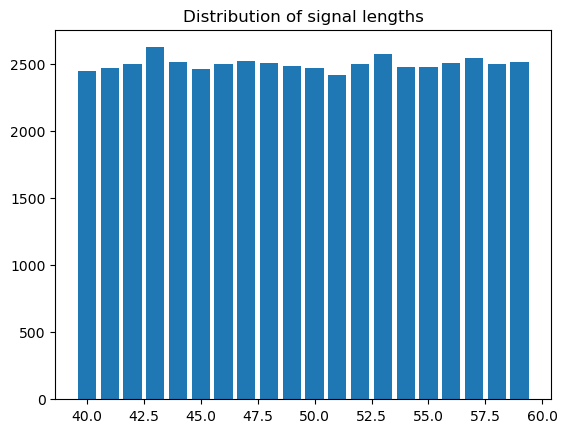

In [208]:
seq_lengths = np.array(list(map(lambda x: x.shape[0], xl)))
plt.bar(*np.unique(seq_lengths, return_counts=True))
plt.title("Distribution of signal lengths")
print(f"0,25,50,75, 100 quantiles: {np.quantile(seq_lengths, [0,0.25,0.5,0.75,1])}")

Lets see if we could get some insights using some statistics and signal processing techniques

We start from just mean and std of the signal

In [209]:
#calculating mean/std per single signal grouping it by defect type
seq_stats = pd.DataFrame(map(lambda x: (*x[0].mean(axis=0), *x[0].std(axis=0),*x[1]), zip(xl,yl)), 
                        columns=[f"mean{i+1}" for i in range(3)] +[f"std{i+1}" for i in range(3)] + [f"def{i+1}" for i in range(5)])

In [210]:
# filter the data so that plotnine dpesn't die. Trends should be still visible
seq_stats = seq_stats.iloc[np.random.choice(np.arange(n), size=n//10, replace=False),:]
# Melt it so that it is any plotting library friendly
seq_stats_melted = pd.melt(seq_stats, id_vars=['mean1', 'mean2', 'mean3', 'std1', 'std2','std3'], value_vars=['def1','def2','def3','def4','def5' ])

For every sample and each signal within we calculated means and std deviations and we also have information if some defects was visible or not.

In [211]:
seq_stats_melted.head() # ready to plot

mean1     mean2     mean3      std1      std2      std3 variable  value
0  0.488248  0.496164 -0.027694  0.618528  0.937018  0.987774     def1   True
1  0.195795  0.213692  0.313819  0.715292  0.698706  0.642403     def1  False
2  0.392534  0.217851  0.009005  0.998958  0.704905  0.709358     def1  False
3  0.258350  0.219207  0.232448  0.792932  0.712898  0.685316     def1   True
4  0.247935  0.206995  0.221827  0.701027  0.702768  0.684955     def1  False

We plot just means as standard deviations was not that interesting

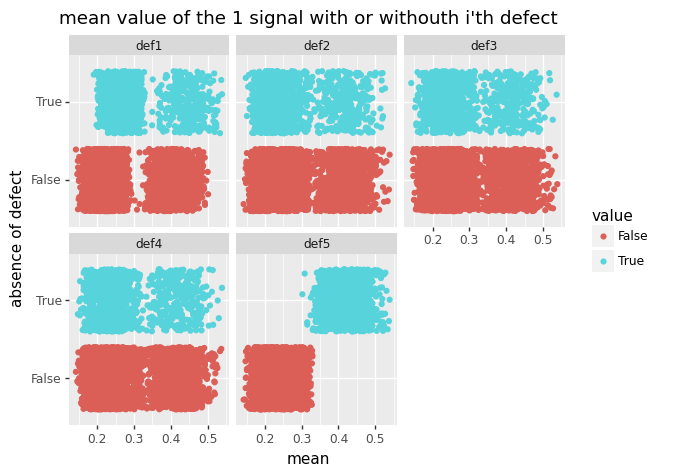

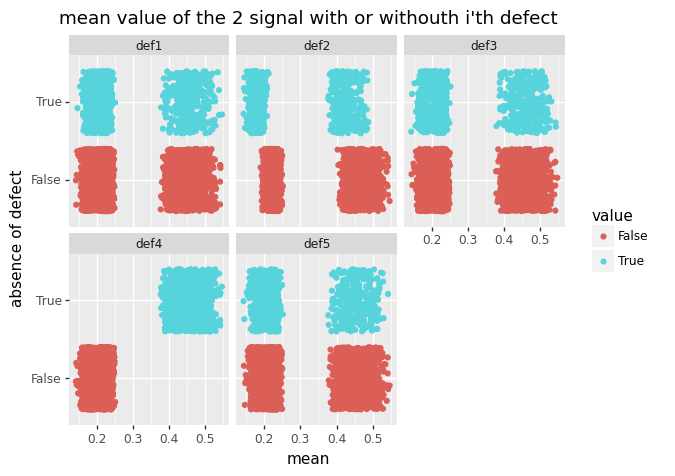

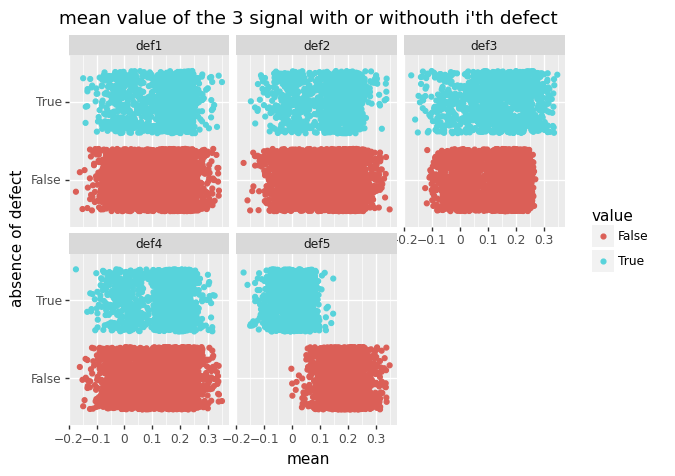

In [212]:
for x_name in ['mean1','mean2', 'mean3']:
    fig = ggplot(seq_stats_melted) + aes(x=x_name, y="value", color="value")\
         + geom_jitter() + facet_wrap('variable')\
        + labs(x=x_name[:-1],
          y="absence of defect",
          title=f"{x_name[:-1]} value of the {x_name[-1]} signal with or withouth i'th defect",
    )

    fig.draw()
    

Taking only mean We can find a cause of 2 out of 5 defects. Defect 4 is some longer positive peak on signal 2 that's why mean is shifted to the right. Defect 5 is combination of singal 1 and 3. For the rest of the defects simple statistics are not enough. This may be because these are too short or caused by characteristics that doesn't shift mean or std by much.

#### Try applying smoothing techniques to get original signal and find anomalies
If we believed that these perturbances are quite local we may try to smooth the signal and find outliers via subtraction. Next we can just select biggest residual from the signal

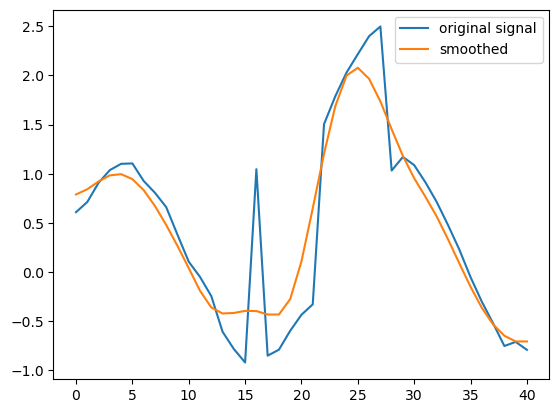

In [213]:
plt.plot(xl[3][:,0], label="original signal")
#smooth function is defined in utils
plt.plot(utils.smooth(xl[3][:,0], window_len = 10), label="smoothed")
plt.legend()

In [214]:
absolute_deviations = []
for x in xl:
    smoothed = []
    for i in range(3):
        # We must apply smoothing to every signal separately and the aggregate
        smoothed.append(utils.smooth(x[:,i], window_len = 10))
    smoothed = np.array(smoothed).T
    #We are interested in just a magnitude of deviation
    absolute_deviations.append(np.abs(x-smoothed))

In [215]:
deviations_stats = pd.DataFrame(map(lambda x: (*x[0].max(axis=0), *x[1]), zip(absolute_deviations, yl)), 
                        columns=[f"max{i+1}" for i in range(3)] + [f"def{i+1}" for i in range(5)])

deviations_stats = deviations_stats.iloc[np.random.choice(np.arange(n), size=n//5, replace=False),:]
deviations_stats_melted = pd.melt(deviations_stats, id_vars=['max1', 'max2', 'max3'], value_vars=['def1','def2','def3','def4','def5' ])

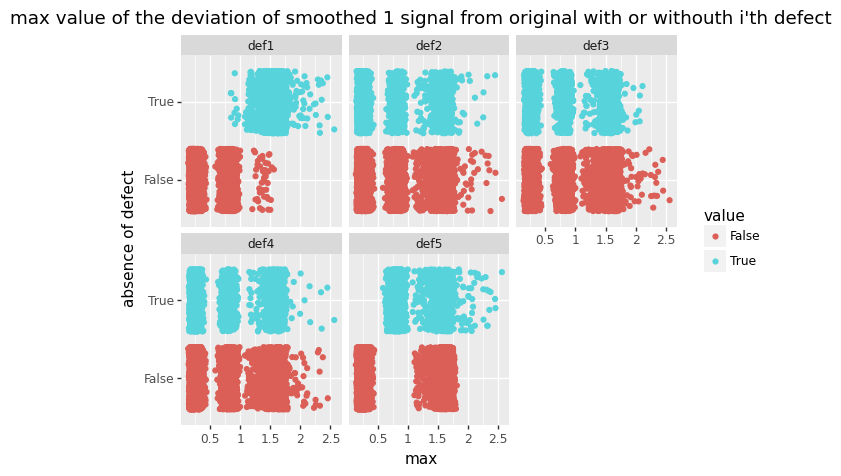

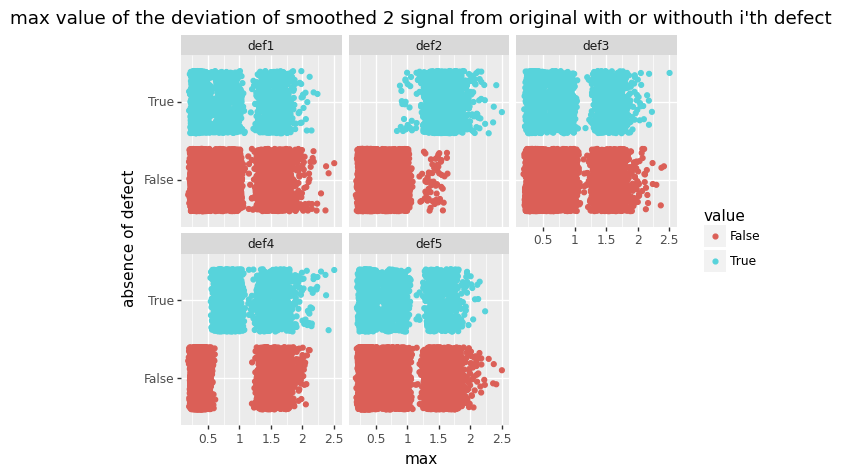

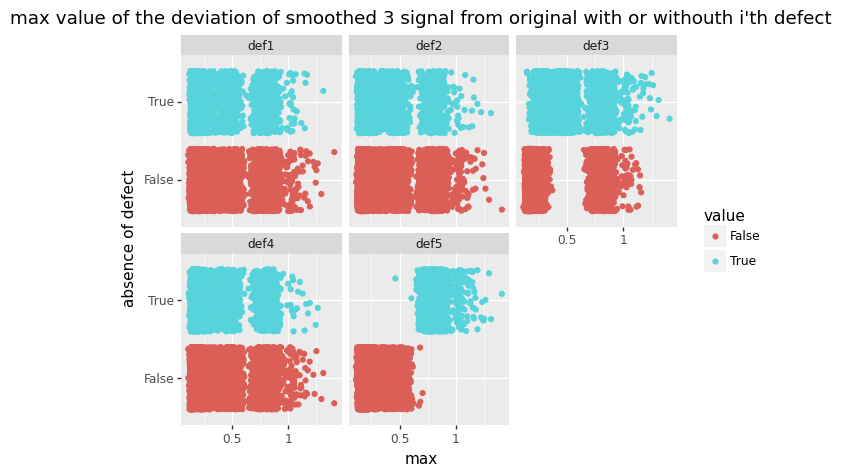

In [216]:
for x_name in ['max1','max2', 'max3']:
    fig = ggplot(deviations_stats_melted) + aes(x=x_name, y="value", color="value")\
         + geom_jitter() + facet_wrap('variable')\
        + labs(x=x_name[:-1],
          y="absence of defect",
          title=f"{x_name[:-1]} value of the deviation of smoothed {x_name[-1]} signal from original with or withouth i'th defect",
    )

    fig.draw()
    

With this method we were able to determine that defect 1 is caused by signal 1 and defect 2 by signal 2. Still defect number 3 is not detected. Also fact that multiple defects can occur simultaneously makes this harder to define this just by statistics.

#### Using derivative

We may check if these defects might have been created by some transients in the signal. Results should've been similar to smoothing. Also occurance of few defects at the same time makes it a little bit harder to, as one should use some fancy method of aggregation. Simple max may give false positives. But just for sake of showning it lets use max

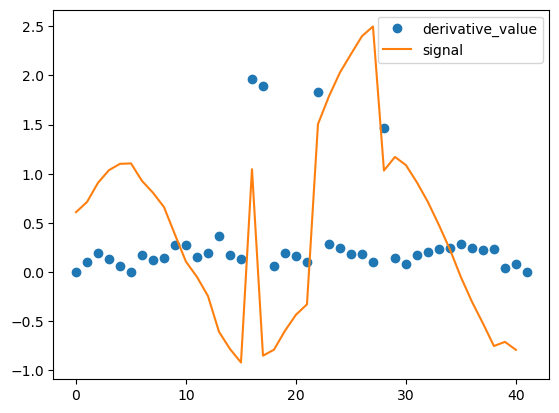

In [217]:
from scipy.signal import convolve

analyzed_signal = xl[3][:,0]
# Pad signal so that we have nice values of derivatives at first step
analyzed_signal = np.concatenate([[analyzed_signal[0]], analyzed_signal, [analyzed_signal[-1]]])
#first order derivative approximation and absolute value to have magnitude only
plt.plot(np.abs(convolve(analyzed_signal, [1,-1]))[1:-1], linestyle='None', marker="o", label="derivative_value")
plt.plot(xl[3][:,0], label="signal") #first order derivative approximation
plt.legend()

In [218]:
absolute_gradients = []
for x in xl:
    gradient = []
    analyzed_signal = np.concatenate([[x[0]], x, [x[-1]]])
    for i in range(3):
        # Probably this could be done easily for all signal at once but scipy convolve doesn't support it
        gradient.append(convolve(analyzed_signal[:,i], [1,-1])[1:-1])

    absolute_gradients.append(np.abs(np.array(gradient).T))

In [219]:
gradients_stats = pd.DataFrame(map(lambda x: (*x[0].max(axis=0), *x[1]), zip(absolute_gradients, yl)), 
                        columns=[f"max{i+1}" for i in range(3)] + [f"def{i+1}" for i in range(5)])

gradients_stats = gradients_stats.iloc[np.random.choice(np.arange(n), size=n//5, replace=False),:]
gradients_stats_melted = pd.melt(gradients_stats, id_vars=['max1', 'max2', 'max3'], value_vars=['def1','def2','def3','def4','def5' ])

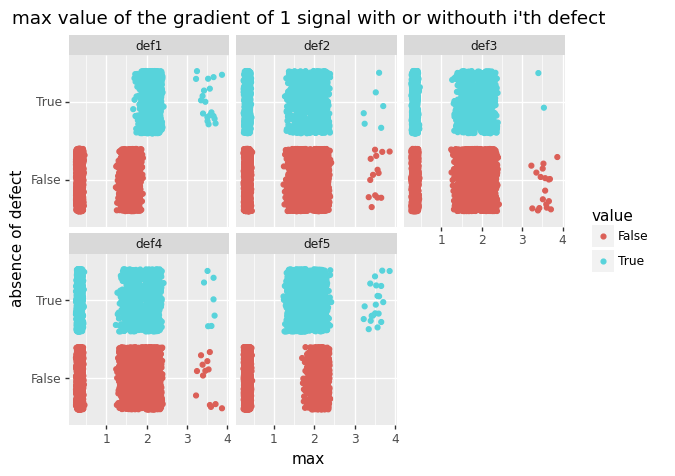

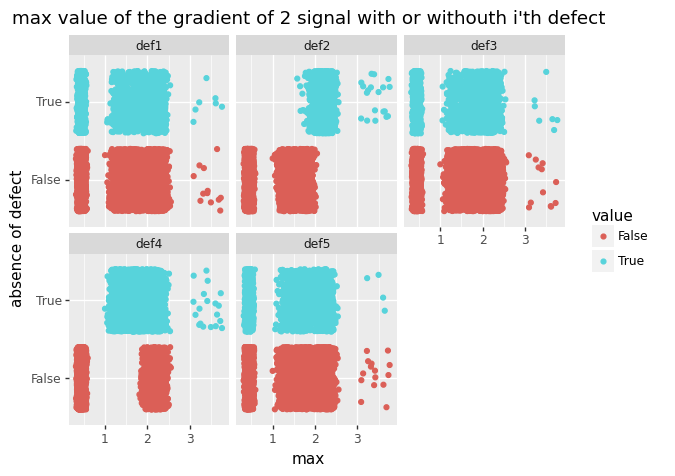

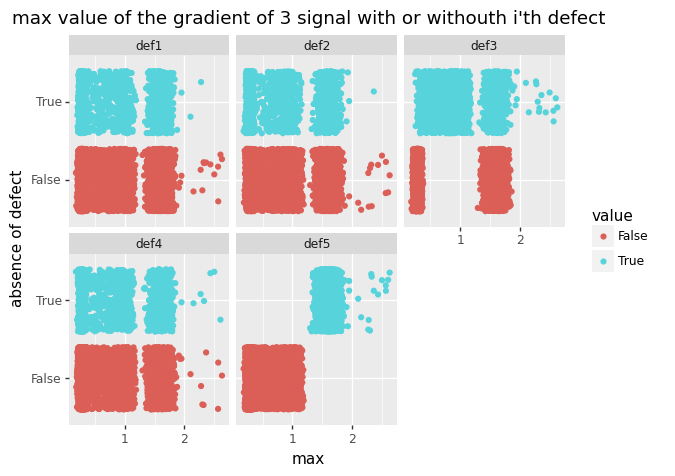

In [220]:
for x_name in ['max1','max2', 'max3']:
    fig = ggplot(gradients_stats_melted) + aes(x=x_name, y="value", color="value")\
         + geom_jitter() + facet_wrap('variable')\
        + labs(x=x_name[:-1],
          y="absence of defect",
          title=f"{x_name[:-1]} value of the gradient of {x_name[-1]} signal with or withouth i'th defect",
    )

    fig.draw()
    

Similar findings as before. Probably approach with smoothing or gradient would do the job if instead of simple statistics some more sophisticated approach was used. But since this is not the goal of this project let's move to the DL approach. Still it seems to be reasonable to always play around with what you can get withouth DL. Also creating a baseline out of these methods that we are sure about it's score would be good idea to know if our DL model performs better than some easy heuristics. 

## DL approach

In [221]:
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, RepeatVector, TimeDistributed, SimpleRNN
from tensorflow.keras.layers import Reshape, GlobalMaxPool1D, Lambda, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
import tensorflow.keras.backend as K
import tensorflow as tf


In [222]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, enable=True)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


At first we must deal somehow with the fact that all the signals have different lengths. The most commpon approach for this is just to pad it so we do this. If we have problems later on we will refine this method

In [223]:
x = []
for series in xl:
    if len(series) < 60:
        tmp = np.concatenate([series, np.zeros((60-len(series),3))]) #pad with zeros
    x.append(tmp)

In [224]:
x, yl = np.array(x), np.array(yl)

In [225]:
x.shape, yl.shape

((50000, 60, 3), (50000, 5))

Next, we should split the data into train/test/val sets. We do this simply using 80/10/10 proportion

In [226]:
train_split = 0.8
val_split = 0.9

split1 = int(len(x)*train_split)
split2 =  int(len(x)*val_split)

train_x, train_y = x[:split1], yl[:split1]
val_x, val_y = x[split1:split2], yl[split1:split2]
test_x, test_y = x[split2:], yl[split2:]


In [227]:
train_x.shape, train_y.shape

((40000, 60, 3), (40000, 5))

Then, we can add our DL baseline model - SimpleRNN

In [228]:
simple_model = Sequential()
simple_model.add(SimpleRNN(32, input_shape=(None,3)))
simple_model.add(Dense(5, activation='sigmoid'))
simple_model.compile(loss='binary_crossentropy', metrics=[
              tf.keras.metrics.BinaryAccuracy()])
simple_model.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1152      
                                                                 
 dense_7 (Dense)             (None, 5)                 165       
                                                                 
Total params: 1,317
Trainable params: 1,317
Non-trainable params: 0
_________________________________________________________________


In [229]:
simple_model.fit(train_x, train_y, batch_size=64, epochs=50,
          validation_data=(val_x, val_y), callbacks=[utils.get_callbacks("baseline_rnn")])


Epoch 1/50
625/625 [==============================] - 21s 32ms/step - loss: 0.4901 - binary_accuracy: 0.7843 - val_loss: 0.4586 - val_binary_accuracy: 0.8005 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - 21s 34ms/step - loss: 0.4605 - binary_accuracy: 0.7969 - val_loss: 0.4508 - val_binary_accuracy: 0.8030 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - 20s 32ms/step - loss: 0.4491 - binary_accuracy: 0.8074 - val_loss: 0.4086 - val_binary_accuracy: 0.8284 - lr: 0.0010
Epoch 4/50
625/625 [==============================] - 19s 31ms/step - loss: 0.3925 - binary_accuracy: 0.8292 - val_loss: 0.3529 - val_binary_accuracy: 0.8458 - lr: 0.0010
Epoch 5/50
625/625 [==============================] - 20s 33ms/step - loss: 0.3689 - binary_accuracy: 0.8385 - val_loss: 0.3369 - val_binary_accuracy: 0.8506 - lr: 0.0010
Epoch 6/50
625/625 [==============================] - 20s 32ms/step - loss: 0.3581 - binary_accuracy: 0.8429 - val_loss: 0.3342 - val_binary_accu

In [230]:
simple_model.evaluate(test_x, test_y)

157/157 [==============================] - 2s 11ms/step - loss: 0.1608 - binary_accuracy: 0.9368


[0.16080555319786072, 0.9368000030517578]

The simplest RNN gives us validation and test accuracy of ~85%. It's pretty decent, but we can do better. Let's try with one LSTM layer now.

In [231]:
model = Sequential()
model.add(LSTM(64, input_shape=(None, 3)))
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='binary_crossentropy', metrics=[
              tf.keras.metrics.BinaryAccuracy()])
model.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 64)                17408     
                                                                 
 dense_8 (Dense)             (None, 5)                 325       
                                                                 
Total params: 17,733
Trainable params: 17,733
Non-trainable params: 0
_________________________________________________________________


In [232]:
model.fit(train_x, train_y, batch_size=64, epochs=50,
          validation_data=(val_x, val_y), callbacks=utils.get_callbacks("lstm"))

Epoch 1/50
625/625 [==============================] - 8s 10ms/step - loss: 0.4224 - binary_accuracy: 0.8138 - val_loss: 0.3129 - val_binary_accuracy: 0.8653 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - 5s 9ms/step - loss: 0.2979 - binary_accuracy: 0.8712 - val_loss: 0.2801 - val_binary_accuracy: 0.8806 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - 5s 8ms/step - loss: 0.2595 - binary_accuracy: 0.8889 - val_loss: 0.2352 - val_binary_accuracy: 0.8962 - lr: 0.0010
Epoch 4/50
625/625 [==============================] - 6s 9ms/step - loss: 0.2408 - binary_accuracy: 0.8965 - val_loss: 0.2191 - val_binary_accuracy: 0.9091 - lr: 0.0010
Epoch 5/50
625/625 [==============================] - 6s 9ms/step - loss: 0.2243 - binary_accuracy: 0.9042 - val_loss: 0.1870 - val_binary_accuracy: 0.9208 - lr: 0.0010
Epoch 6/50
625/625 [==============================] - 6s 9ms/step - loss: 0.2094 - binary_accuracy: 0.9125 - val_loss: 0.1783 - val_binary_accuracy: 0.927

In [233]:
model.evaluate(val_x, val_y)


157/157 [==============================] - 1s 5ms/step - loss: 0.0122 - binary_accuracy: 0.9965


[0.012247161939740181, 0.9964799880981445]

In [234]:
model.evaluate(test_x, test_y)

157/157 [==============================] - 1s 5ms/step - loss: 0.0107 - binary_accuracy: 0.9968


[0.010705588385462761, 0.9968000054359436]

Lets make sure that padding hasn't influenced anything, as signals are quite short. It doesn't look so as if it indeed biased model towards something we probably won't be getting such good accuracy.

In [235]:
test_x_no_pad = xl[split2:]

In [236]:
#passing every element separately is quite slow, but such a sanity check should be done
results_no_pad = np.array([model.predict(x[None,:,:], verbose=0) for x in test_x_no_pad])

In [237]:
acc = tf.keras.metrics.BinaryAccuracy()
acc.update_state(yl[split2:], results_no_pad[:,0,:])
acc.result().numpy()

0.99208

In [238]:
acc = tf.keras.metrics.BinaryAccuracy()
acc.update_state(yl[split2:], model.predict(test_x))
acc.result().numpy()

157/157 [==============================] - 1s 4ms/step


0.9968

Small deterioration (very small one) is visible this may be because this additional padding allows the model to saturate more and when padding is removed for some samples it won't be able to saturate?


Lets try small redefinition of the model, and train it so that the maximum prediction should be correct. Now model doesn't have to saturate till very end, but just needs to fire at specific moment. Such approach may be useful when we have weak labels. Hopefully later model scores will give us locations of the defects

In [239]:

model = Sequential()
model.add(LSTM(64, input_shape=(None, 3), return_sequences=True))
model.add(Dense(5)) # by default we have linear activation
# Now this is enough to remove this GlobalMaxPooling after training and explainability would be done in one shot (hopefully)?
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Activation("sigmoid"))
model.compile(loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, None, 64)          17408     
                                                                 
 dense_9 (Dense)             (None, None, 5)           325       
                                                                 
 global_max_pooling1d_6 (Glo  (None, 5)                0         
 balMaxPooling1D)                                                
                                                                 
 activation_4 (Activation)   (None, 5)                 0         
                                                                 
Total params: 17,733
Trainable params: 17,733
Non-trainable params: 0
_________________________________________________________________


In [240]:
model.fit(train_x, train_y, batch_size=64, epochs=50,
          validation_data=(val_x, val_y), callbacks=utils.get_callbacks("lstm_max_pool"))

Epoch 1/50
625/625 [==============================] - 8s 10ms/step - loss: 0.3941 - binary_accuracy: 0.8573 - val_loss: 0.2516 - val_binary_accuracy: 0.8981 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - 6s 9ms/step - loss: 0.2362 - binary_accuracy: 0.8978 - val_loss: 0.2129 - val_binary_accuracy: 0.9104 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - 6s 9ms/step - loss: 0.1816 - binary_accuracy: 0.9257 - val_loss: 0.1206 - val_binary_accuracy: 0.9672 - lr: 0.0010
Epoch 4/50
625/625 [==============================] - 6s 9ms/step - loss: 0.0711 - binary_accuracy: 0.9787 - val_loss: 0.0365 - val_binary_accuracy: 0.9900 - lr: 0.0010
Epoch 5/50
625/625 [==============================] - 6s 10ms/step - loss: 0.0271 - binary_accuracy: 0.9922 - val_loss: 0.0163 - val_binary_accuracy: 0.9961 - lr: 0.0010
Epoch 6/50
625/625 [==============================] - 6s 10ms/step - loss: 0.0166 - binary_accuracy: 0.9954 - val_loss: 0.0113 - val_binary_accuracy: 0.9

This model seems to be much simpler to train, it obtains good results sonner than just LSTM

In [241]:
results_no_pad = np.array([model.predict(x[None,:,:], verbose=0) for x in test_x_no_pad])

In [242]:
acc = tf.keras.metrics.BinaryAccuracy()
acc.update_state(yl[split2:], results_no_pad[:,0,:])
acc.result().numpy()

0.99736

We obtain very good results - 99.8% binary accuracy on the both test and validation data. It doesn't make any sense to train it further.

Now let's try to get the exact place of the anomaly. Firstly we use Gradient w.r.t Input method. So we calculate gradient w.r.t one of the outputs.

It works like that: we perform prediction -> For every class where defect was found we calculate gradient -> we threshold and eventually plot

In [259]:
model.load_weights("lstm_maxpool/weights.05-0.02.hdf5")

So we make a prediction and we know that 4th class was found -> we calculate gradient for 4th class

In [260]:
example = train_x[0]
model.predict(example[None,:,:]), train_y[0]

1/1 [==============================] - 0s 27ms/step


(array([[2.0965512e-03, 1.5391038e-03, 1.3129134e-02, 4.1706680e-04,
         9.9987137e-01]], dtype=float32),
 array([False, False, False, False,  True]))

In [261]:
class_for_gradient = 4 # 4 is a class for which we want to know the gradient
gradients_numpy = utils.get_gradient(model, example[None,:,:], class_for_gradient) 

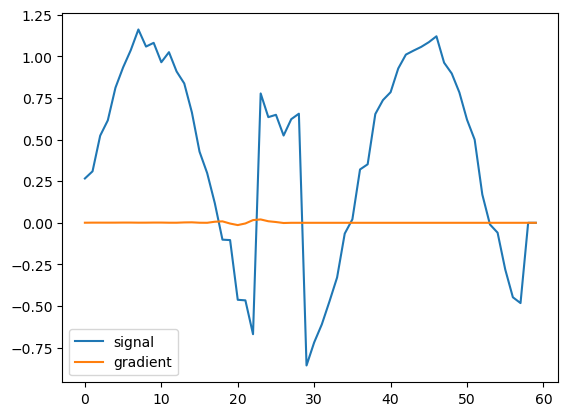

In [264]:
utils.plot_ith_grad(example, gradients_numpy, 0, multiplier=100)   

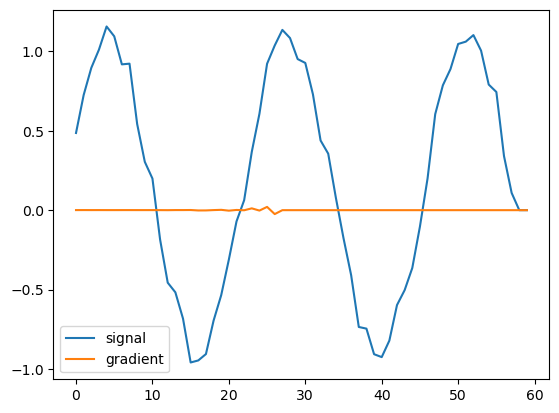

In [265]:
utils.plot_ith_grad(example, gradients_numpy, 1, multiplier=100)   

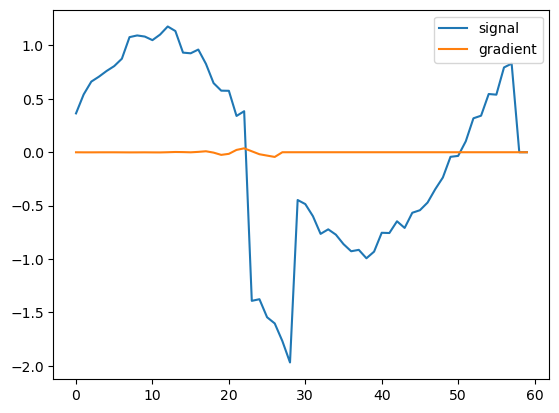

In [266]:
utils.plot_ith_grad(example, gradients_numpy, 2, multiplier=100)   

This somehow works but these gradient's have very small magintude also for the 2nd signal gradient seems to have some small peak which is bad.
This is mainly because network become very confident and saturated for one prediction. Small changes won't change anything. That's why we want to use `integrated gradients`.

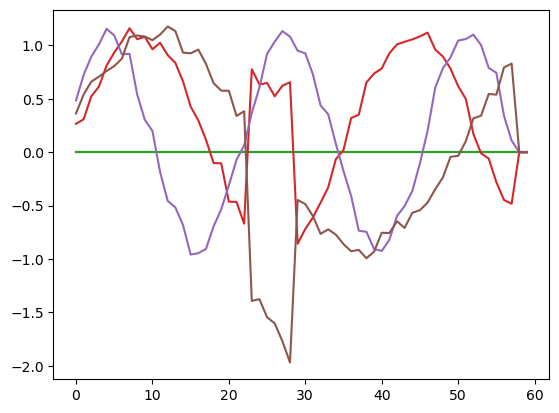

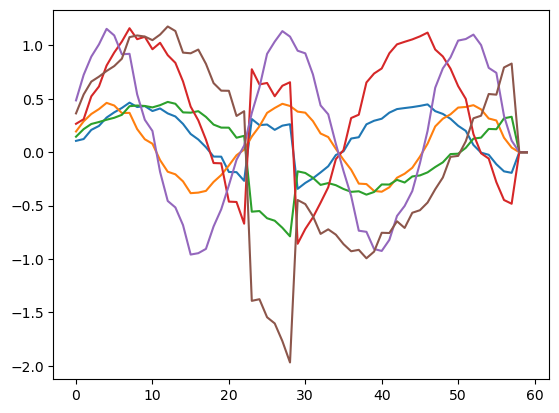

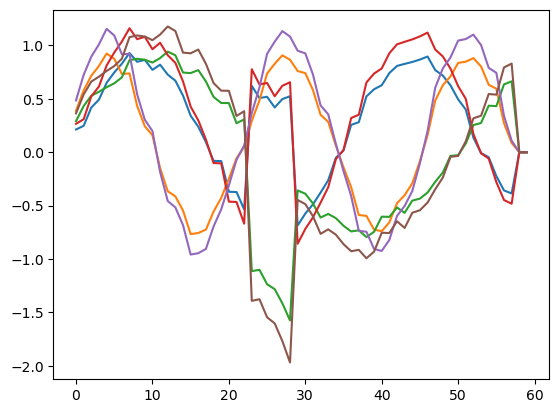

In [267]:
#plot interpolation is just to say which steps of interpolation should be plotted
integrated_grads = utils.get_integrated_gradients(model, example, class_for_gradient, plot_interpolation=[0,2,4])

This plots gets quite messy but the idea is that we interpolate from baseline to our original signal and calculate gradient at each interpolation. Default baseline is 0 signal

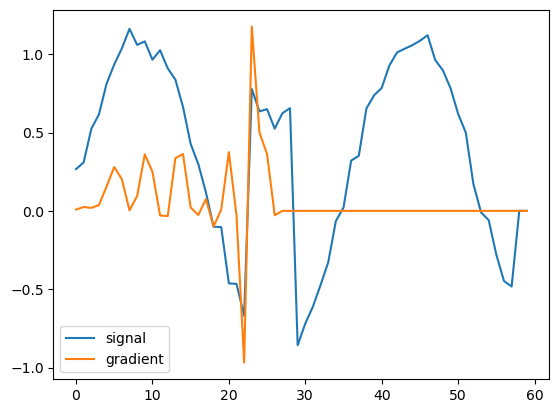

In [268]:
utils.plot_ith_grad(example, integrated_grads, 0) 

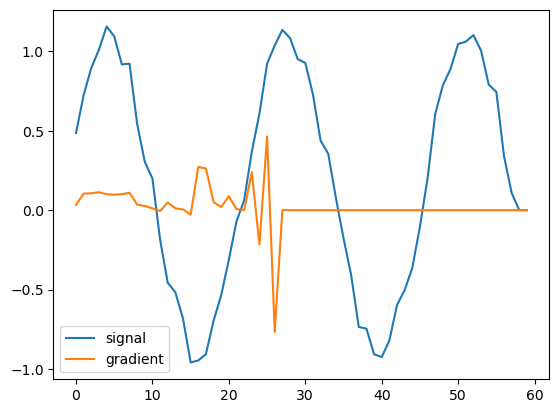

In [269]:
utils.plot_ith_grad(example, integrated_grads, 1) 

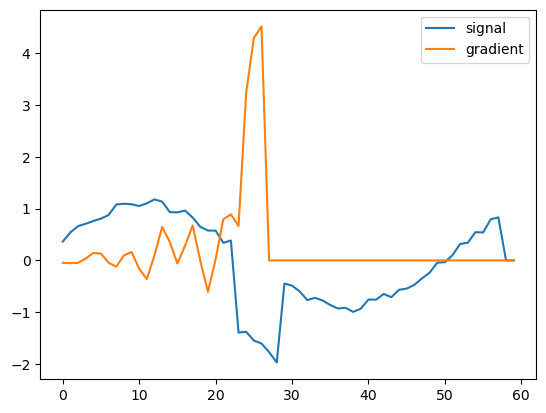

In [270]:
utils.plot_ith_grad(example, integrated_grads, 2) 

Now this work much better, gradients are high where the defects are visible. Also Look at the fact that gradient is 0 after max score was achieved. This actually could be quite bad behaviour during training.

We can also try different baseline. E.g use smoothed signal as a baseline

In [271]:
my_baseline = []
for i in range(3):
    my_baseline.append(utils.smooth(example[:,i], window_len = 20))
my_baseline = np.array(my_baseline).T

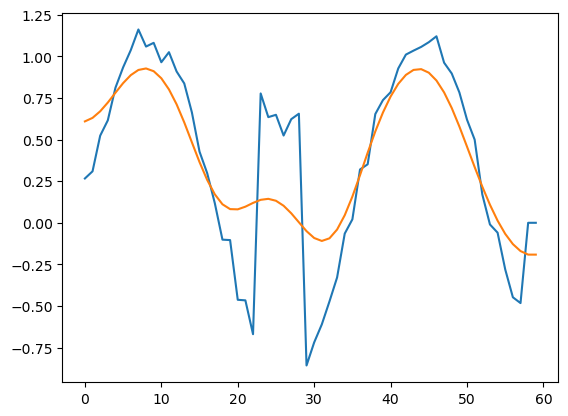

In [272]:
plt.plot(example[:,0])
plt.plot(my_baseline[:,0])

In [273]:
#! Blurred baseline
integrated_grads = utils.get_integrated_gradients(model, example, class_for_gradient,baseline=my_baseline, n_steps=50)

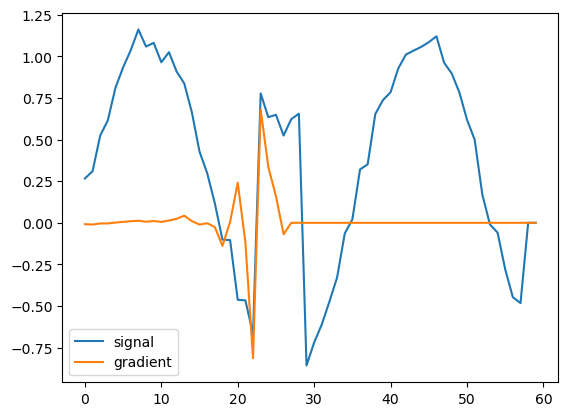

In [274]:
utils.plot_ith_grad(example, integrated_grads, 0) 

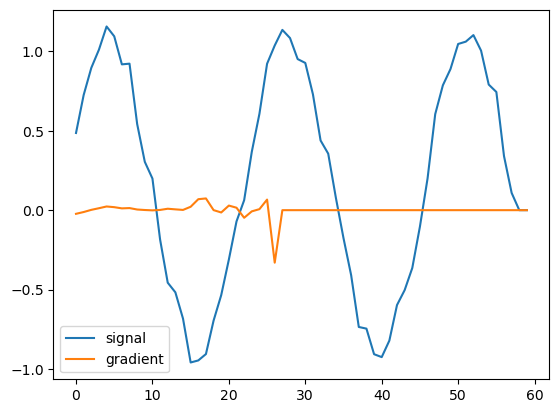

In [275]:
utils.plot_ith_grad(example, integrated_grads, 1) 

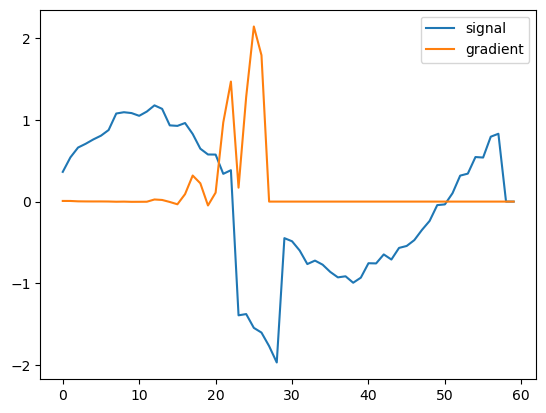

In [276]:
utils.plot_ith_grad(example, integrated_grads, 2) 

This also works nice, lastly we can try to use just some random noise as a baseline

In [277]:
#Uniform baseline
integrated_grads = utils.get_integrated_gradients(model, example, class_for_gradient, baseline=np.random.uniform(0,1,(60,3)), n_steps=50)

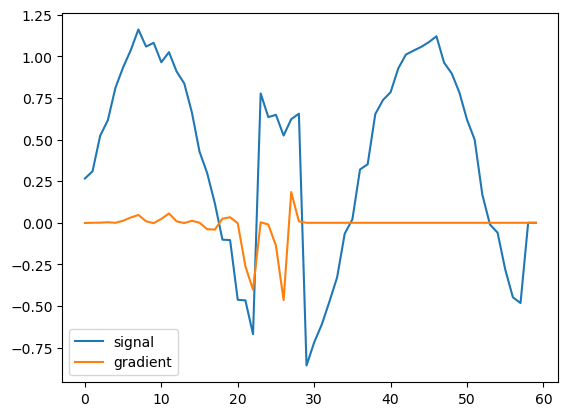

In [278]:
utils.plot_ith_grad(example, integrated_grads, 0) 

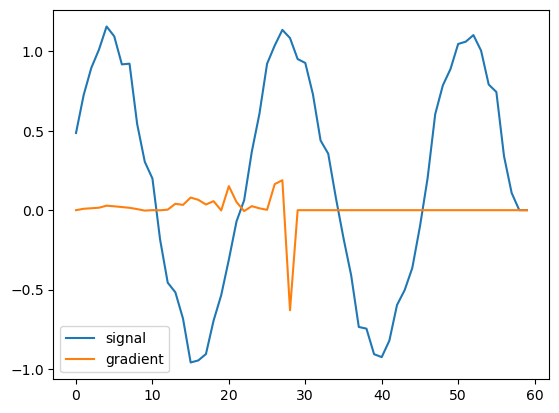

In [279]:
utils.plot_ith_grad(example, integrated_grads, 1) 

But this is not as good as previous baselines

Lets make a function out of it

In [285]:
def integrated_grad_explain(model, example):
    thresholds = [0.8, 0.6,0.4, 0.02, 0.08] # THreshold were selected experimentally
    prediction = model.predict(example[None,:,:])[0]
    print(prediction)
    detected_classes = np.argwhere(prediction > 0.5)[:,0]
    #print(detected_classes)
    plt.plot(example)
    positions_of_text = np.linspace(example.min(), example.max(), 5) 
    for detected_class in detected_classes:
        integrated_grads = np.abs(utils.get_integrated_gradients(model, example, detected_class, n_steps=50)).max(axis=1)
        # for some classes gradients are very big for others they are smaller
        big_gradient_places = np.argwhere(integrated_grads > thresholds[detected_class])
        plt.text(0, positions_of_text[detected_class], f"defect {detected_class}")
        for i in big_gradient_places:
            plt.axvspan(i, i+1, ymin=detected_class/5, ymax=(detected_class+1)/5,
                            color={1: 'red', 2: 'blue', 3: 'green', 4: 'yellow', 5:'silver'}[detected_class+1])
      
    plt.show()

[ True False False False False]
1/1 [==============================] - 0s 27ms/step
[9.9891937e-01 1.3742934e-02 1.0772792e-02 5.4515660e-04 2.4321662e-04]


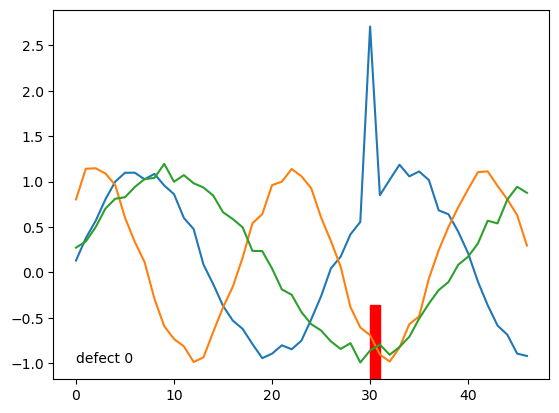

[ True  True  True False False]
1/1 [==============================] - 0s 27ms/step
[9.9976379e-01 9.9987173e-01 9.9948090e-01 4.1957709e-04 1.8413345e-04]


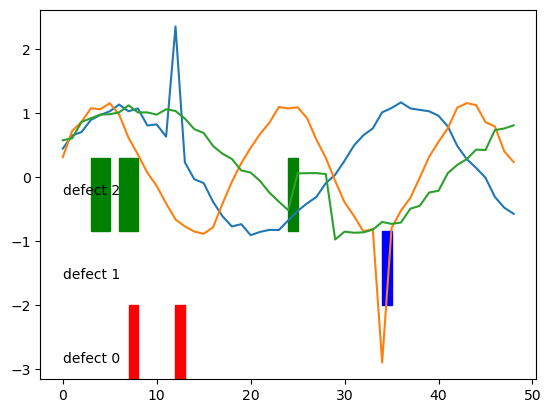

[False  True False  True False]
1/1 [==============================] - 0s 27ms/step
[2.5299860e-03 9.6213555e-01 1.5033623e-02 9.9901509e-01 7.1650473e-05]


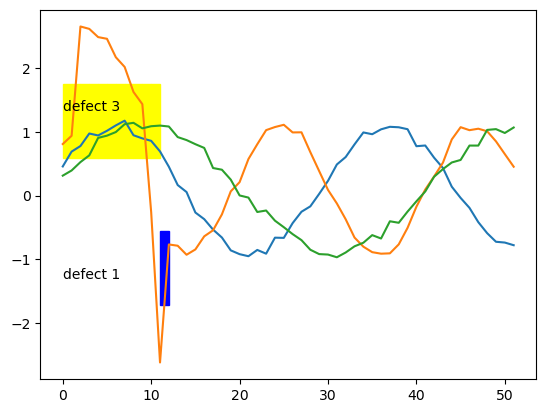

[False False False False False]
1/1 [==============================] - 0s 26ms/step
[0.00317646 0.00111882 0.01523402 0.00082653 0.00020402]


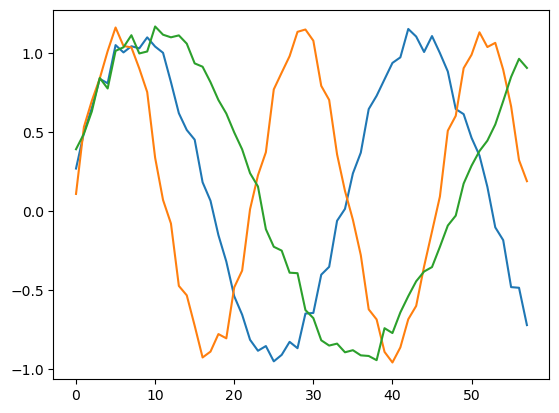

[False False False False False]
1/1 [==============================] - 0s 25ms/step
[2.9158374e-04 2.8746305e-03 7.5777541e-03 2.7424656e-05 1.1846517e-05]


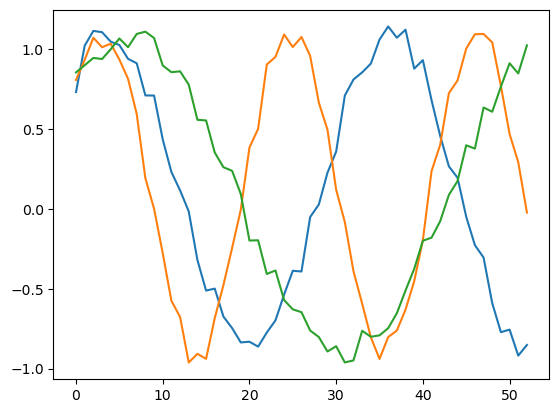

[ True  True False False False]
1/1 [==============================] - 0s 26ms/step
[9.9931192e-01 9.9996257e-01 1.9336816e-02 1.4540278e-04 2.5369690e-04]


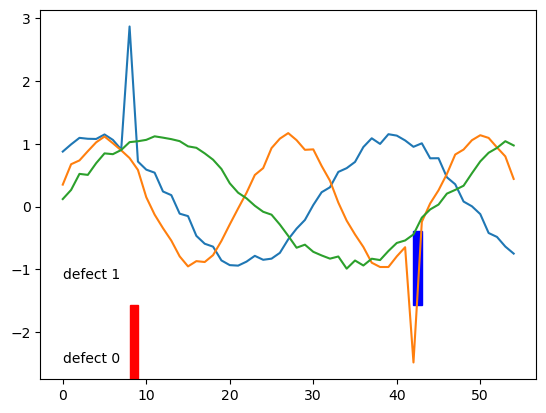

[ True  True False False  True]
1/1 [==============================] - 0s 25ms/step
[7.4258357e-01 9.9981958e-01 1.0955870e-01 1.5242683e-04 9.9990582e-01]


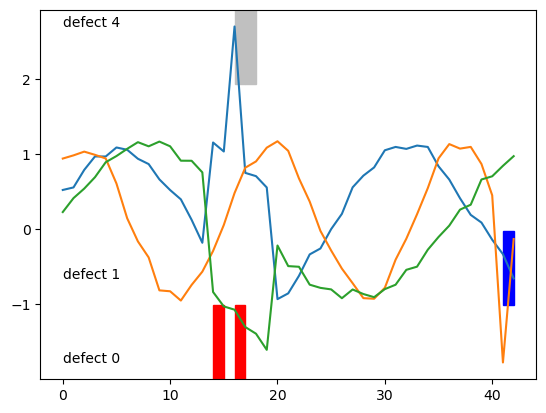

[ True  True False False False]
1/1 [==============================] - 0s 25ms/step
[9.9851614e-01 9.9979180e-01 5.8781337e-03 2.0798916e-04 2.0227772e-04]


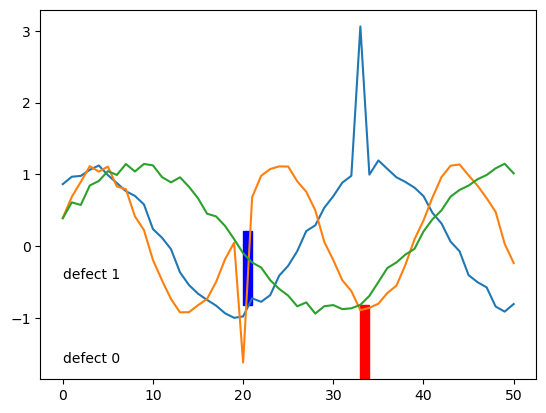

[False  True False False False]
1/1 [==============================] - 0s 23ms/step
[6.3829654e-04 9.9951470e-01 2.6456849e-03 4.7737158e-05 4.7024125e-05]


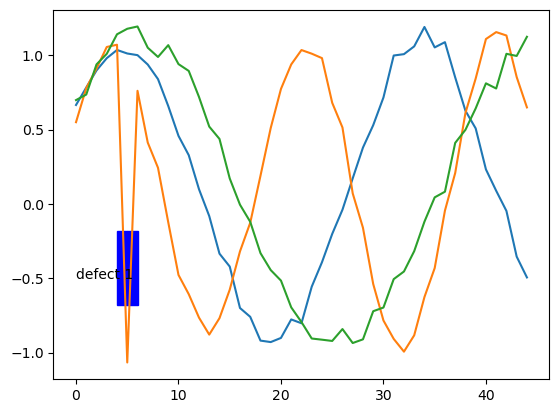

[ True False False False False]
1/1 [==============================] - 0s 25ms/step
[9.9962771e-01 3.4846310e-03 1.2361998e-02 6.4775714e-04 1.3308380e-04]


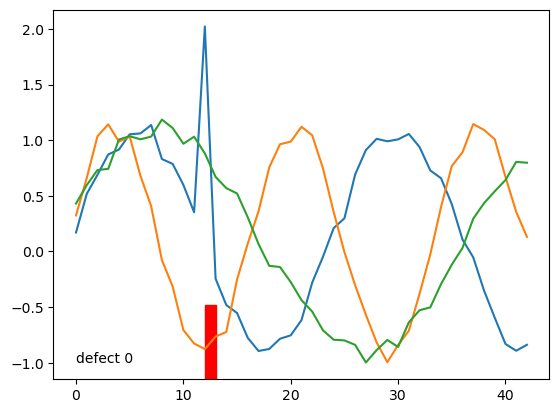

[False False False False False]
1/1 [==============================] - 0s 26ms/step
[0.00096208 0.00205056 0.01568481 0.00023145 0.00014208]


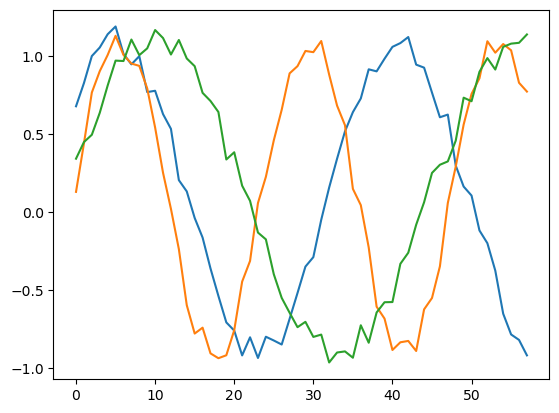

[False False  True  True False]
1/1 [==============================] - 0s 26ms/step
[0.00624378 0.02774149 0.9988807  0.9985654  0.002715  ]


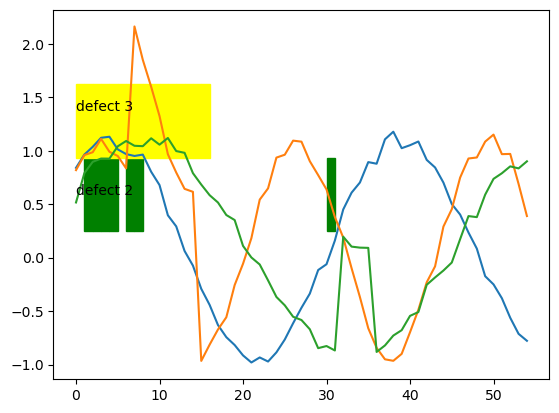

[False False  True False  True]
1/1 [==============================] - 0s 25ms/step
[2.0798903e-03 2.2752306e-03 9.7672993e-01 7.1206232e-05 9.9932539e-01]


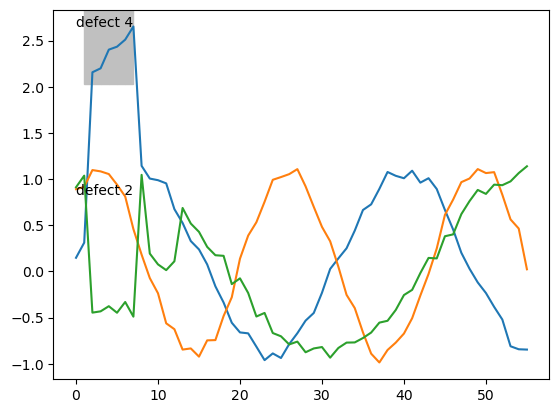

[False  True  True False False]
1/1 [==============================] - 0s 24ms/step
[6.2067048e-03 9.9974686e-01 9.9531555e-01 2.7069225e-04 1.5198896e-04]


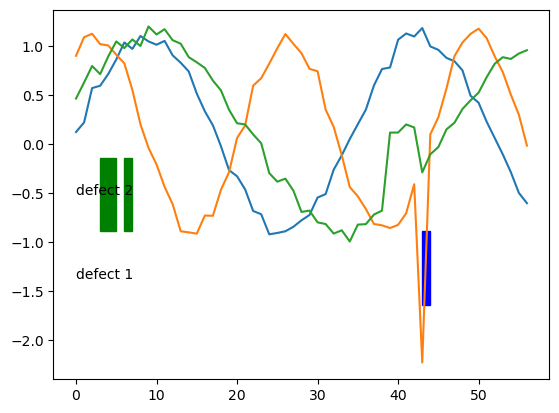

[False  True False False  True]
1/1 [==============================] - 0s 27ms/step
[1.5479245e-03 9.9963999e-01 4.7737215e-02 8.4279905e-05 9.9995029e-01]


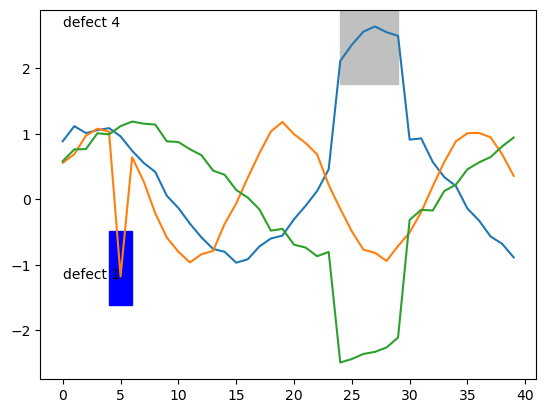

[False  True  True False False]
1/1 [==============================] - 0s 23ms/step
[1.9827012e-02 9.9976856e-01 9.5627338e-01 1.1899837e-03 3.9572379e-04]


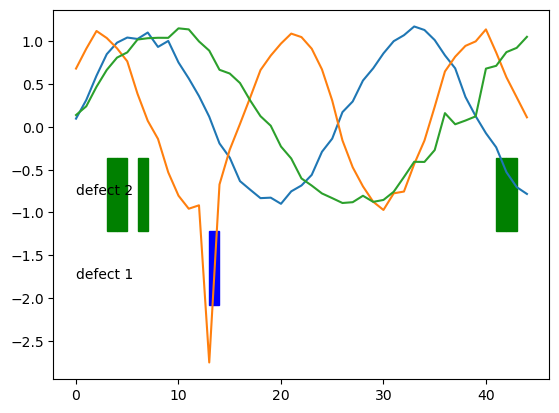

[False False False False False]
1/1 [==============================] - 0s 25ms/step
[5.1445602e-03 1.2354084e-03 1.0195282e-02 1.4570729e-04 9.4846851e-05]


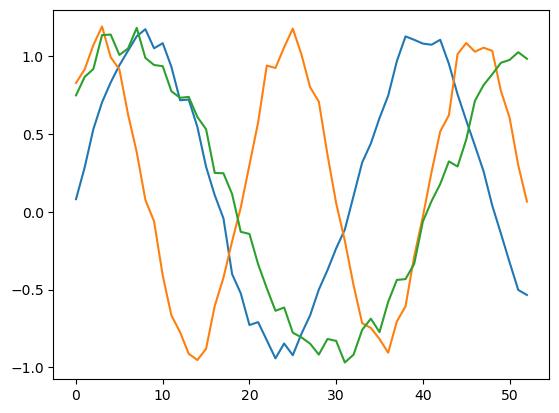

[False False False False False]
1/1 [==============================] - 0s 26ms/step
[5.7866040e-04 6.6916709e-04 3.4451918e-03 6.7551322e-05 1.9905030e-05]


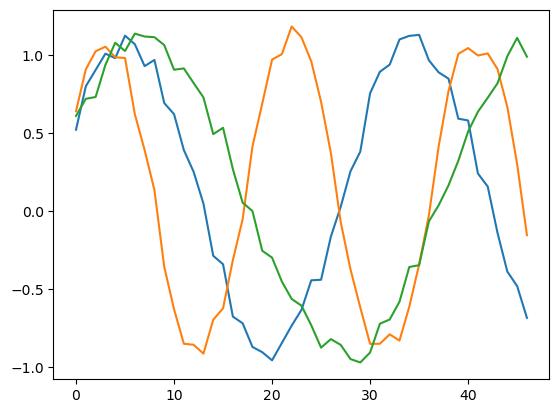

[False False False False False]
1/1 [==============================] - 0s 26ms/step
[3.7335494e-04 2.1650479e-03 1.9722175e-02 9.2908813e-05 1.1489457e-05]


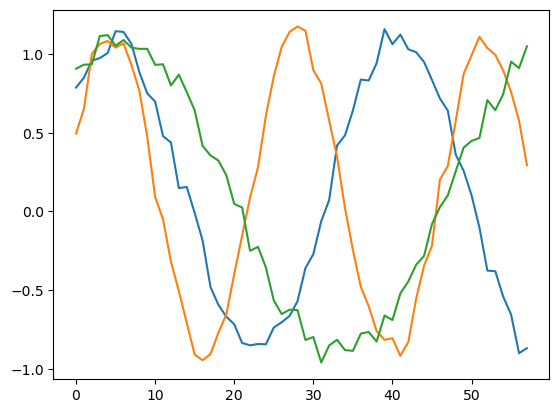

[False  True False False False]
1/1 [==============================] - 0s 28ms/step
[5.6439713e-03 9.9992204e-01 4.7464133e-03 1.6461137e-04 8.8900604e-05]


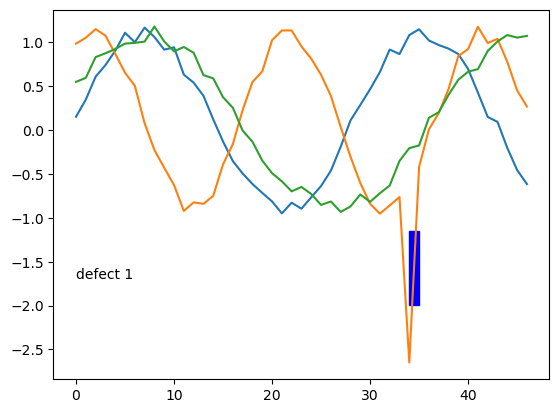

In [286]:
for k in np.random.randint(0, len(xl[split2:]), 20):
    print(yl[split2+k])
    integrated_grad_explain(model,xl[split2+k])

It works quite nice for most of the time. It fails quite badly for defect 2. Probably this is due to baseline being 0 vector.

Now we can try to do a trick, define a model without global max pool  and load weights from max pool. Then try to visualize scores

In [287]:
model = Sequential()
model.add(LSTM(64, input_shape=(None, 3), return_sequences=True))
model.add(Dense(5)) # by default we have linear activation
model.add(tf.keras.layers.Activation("sigmoid"))
model.compile(loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, None, 64)          17408     
                                                                 
 dense_10 (Dense)            (None, None, 5)           325       
                                                                 
 activation_5 (Activation)   (None, None, 5)           0         
                                                                 
Total params: 17,733
Trainable params: 17,733
Non-trainable params: 0
_________________________________________________________________


In [288]:
model.load_weights("lstm_maxpool/weights.05-0.02.hdf5")

Method is very simple, when model is quite sure about it's prediction then we set defect place at this moment

In [295]:
def explain_with_model_outputs(model,example):
    offset = [2,1,3,6,2] # selected empirically as model have to saturate it's predictions are a little bit late w.r.t finish of signal
    prediction = model.predict(example[None,:,:])[0]
    detected_classes = np.argwhere(np.max(prediction,axis=0) > 0.5)[:,0]
    plt.plot(example)
    positions_of_text = np.linspace(example.min(), example.max(), 5) 
    for detected_class in detected_classes:
        big_prediction_places = np.argwhere(prediction[:,detected_class] > 0.8)
        plt.text(0, positions_of_text[detected_class], f"defect {detected_class}")
        for i in big_prediction_places:
            i-=offset[detected_class]
            plt.axvspan(i, i+1, ymin=detected_class/5, ymax=(detected_class+1)/5,
                            color={1: 'red', 2: 'blue', 3: 'green', 4: 'yellow', 5:'silver'}[detected_class+1])

    plt.show()


[False False False False False]
1/1 [==============================] - 0s 29ms/step


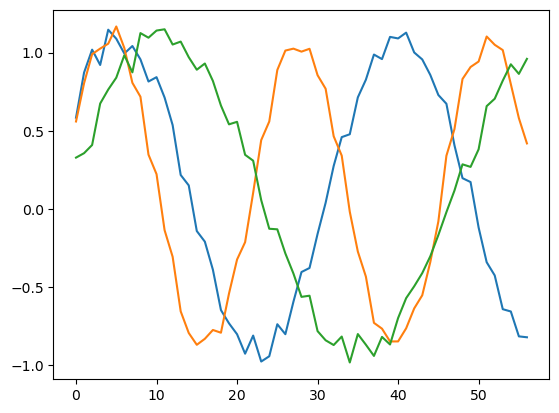

[False False False False False]
1/1 [==============================] - 0s 24ms/step


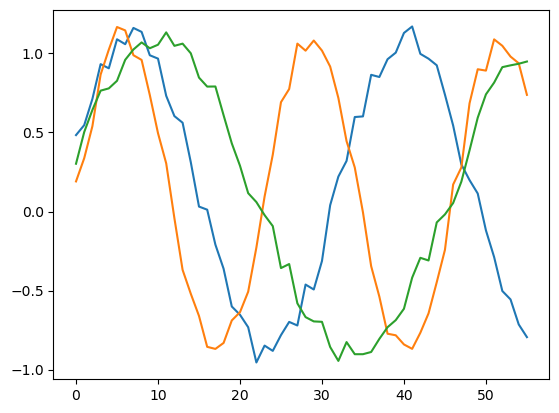

[ True False  True False False]
1/1 [==============================] - 0s 25ms/step


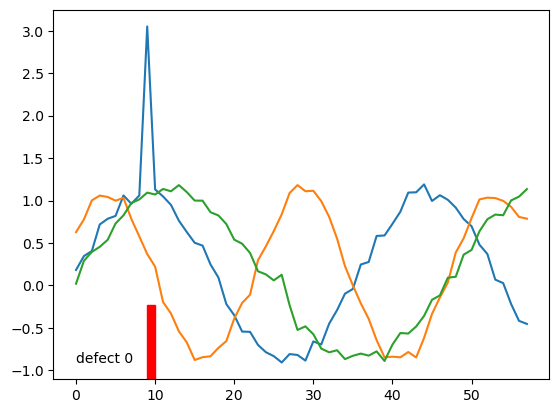

[ True  True  True  True False]
1/1 [==============================] - 0s 25ms/step


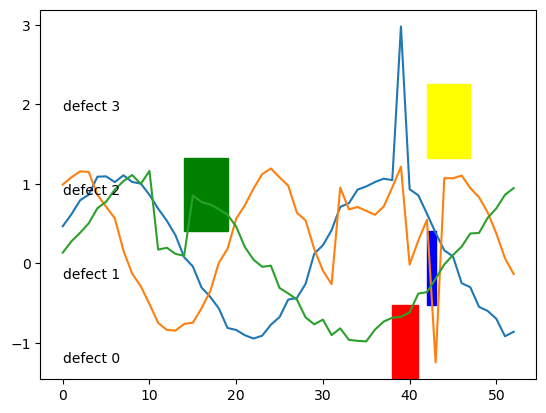

[ True False  True False False]
1/1 [==============================] - 0s 25ms/step


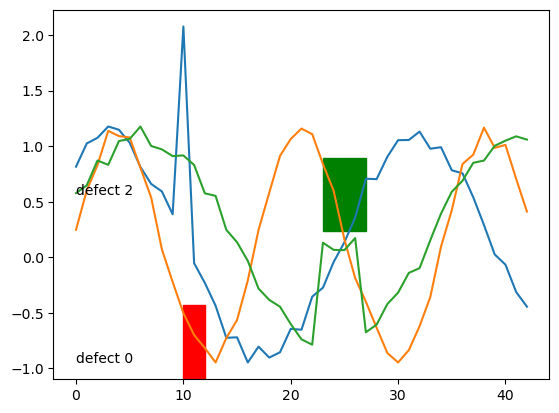

[False False False False  True]
1/1 [==============================] - 0s 25ms/step


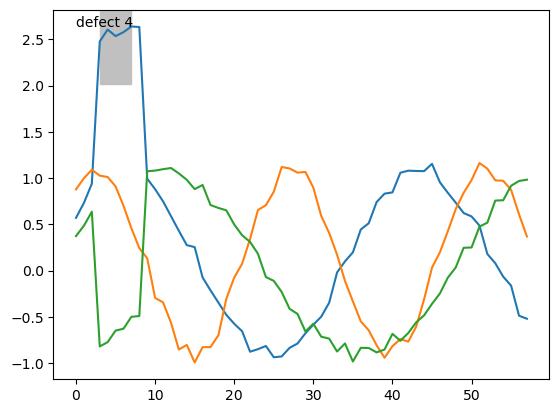

[False False False  True False]
1/1 [==============================] - 0s 26ms/step


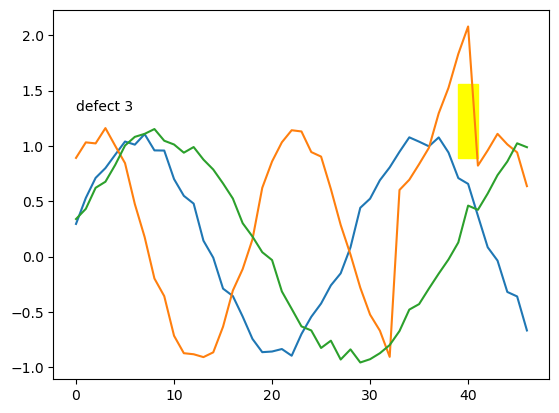

[ True False False False  True]
1/1 [==============================] - 0s 27ms/step


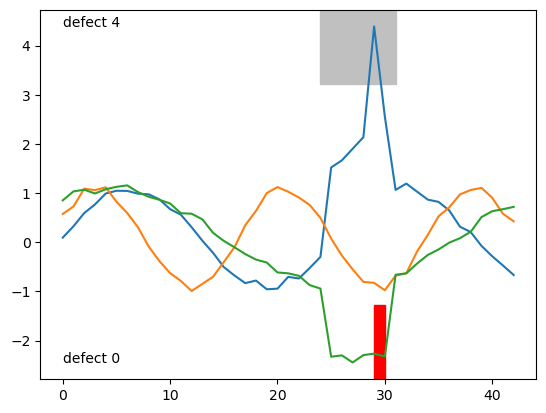

[False False False False False]
1/1 [==============================] - 0s 27ms/step


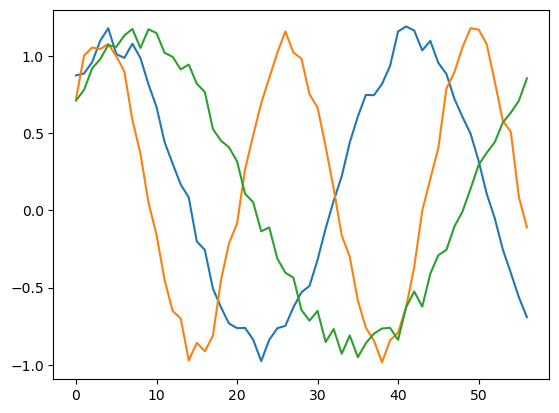

[False False  True False False]
1/1 [==============================] - 0s 25ms/step


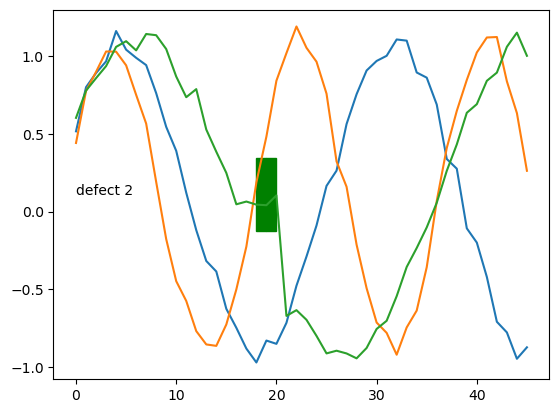

[False  True False  True False]
1/1 [==============================] - 0s 24ms/step


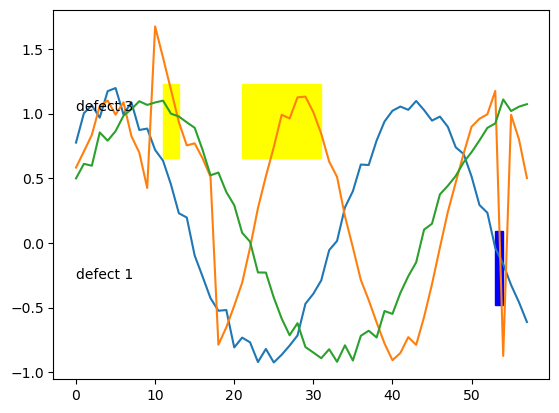

[False False False False False]
1/1 [==============================] - 0s 26ms/step


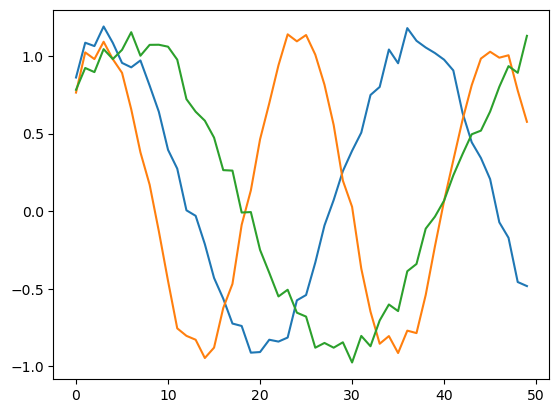

[ True  True  True False False]
1/1 [==============================] - 0s 25ms/step


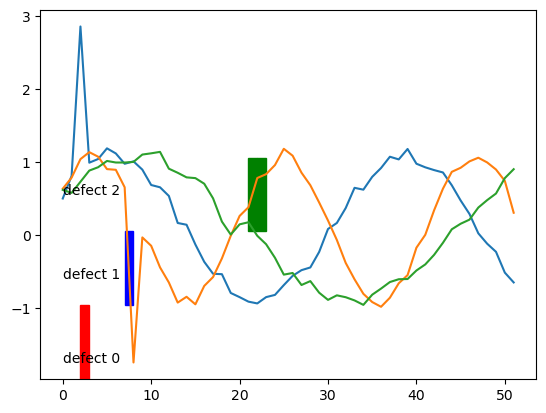

[False False  True False False]
1/1 [==============================] - 0s 26ms/step


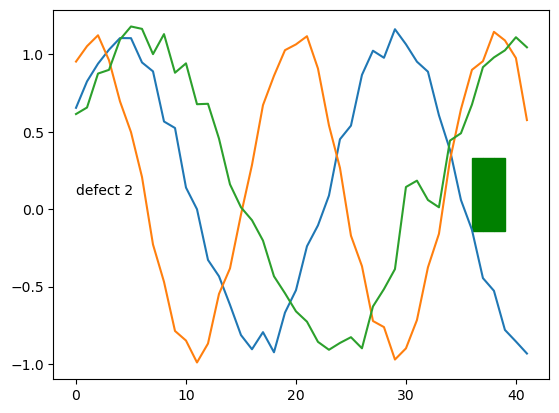

[ True False False  True False]
1/1 [==============================] - 0s 26ms/step


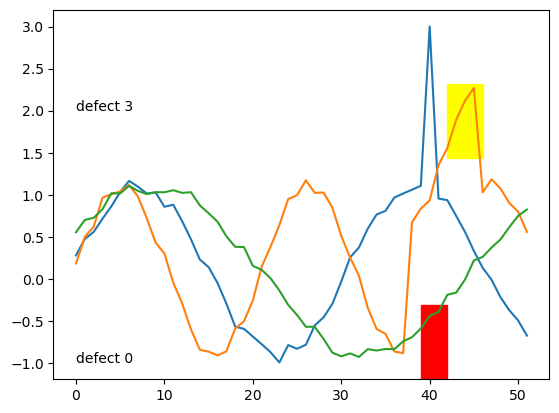

[False False False False False]
1/1 [==============================] - 0s 27ms/step


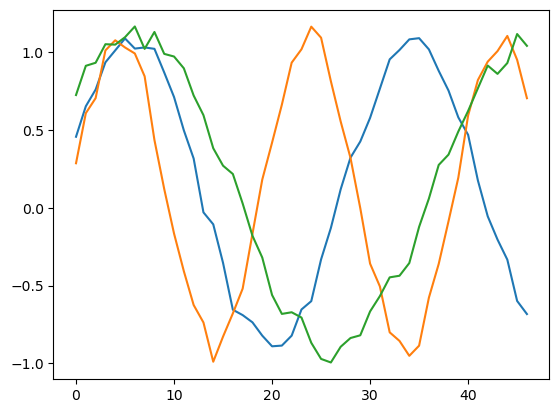

[False  True False False False]
1/1 [==============================] - 0s 27ms/step


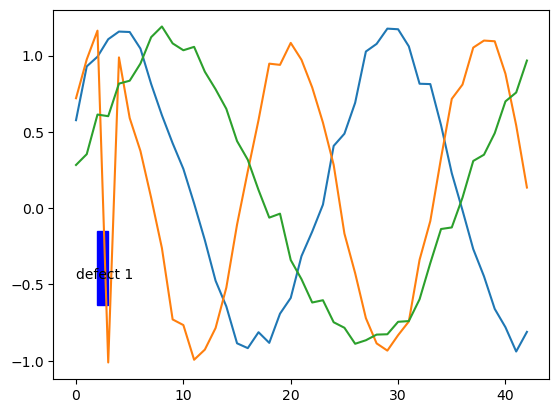

[False  True  True False  True]
1/1 [==============================] - 0s 29ms/step


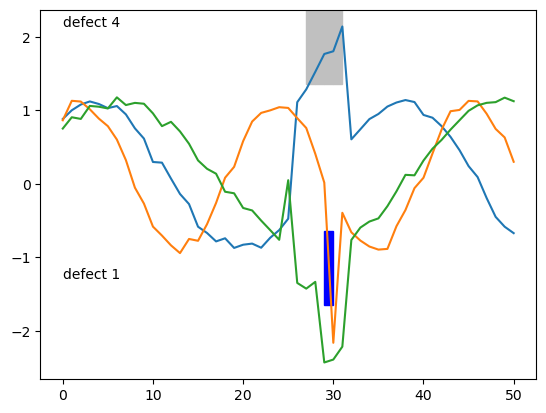

[False False False False False]
1/1 [==============================] - 0s 31ms/step


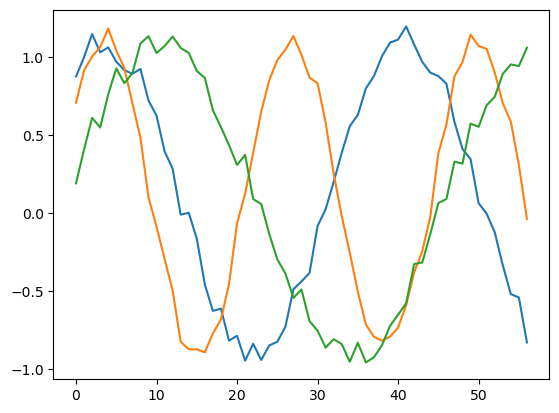

[False False False False  True]
1/1 [==============================] - 0s 27ms/step


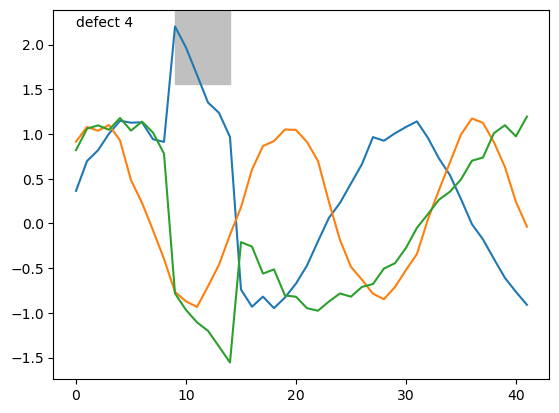

In [296]:
for k in np.random.randint(0, len(xl[split2:]), 20):
    print(yl[split2+k])
    explain_with_model_outputs(model,xl[split2+k])

This method works even better than integrated gradients, still it struggles a little bit with defect 3

Eventually we tried to use method from the lab<br>
Now we can try to explain the model using basic probing approach. Firstly we split the signals to slices, and then fit the model on those slices

In [297]:
miniModel = Sequential()
miniModel.add(LSTM(64, return_sequences=True, input_shape=(None, 3)))
miniModel.add(LSTM(16, return_sequences=False))
miniModel.add(Dense(5, activation='sigmoid'))
miniModel.summary()
miniModel.compile(loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, None, 64)          17408     
                                                                 
 lstm_14 (LSTM)              (None, 16)                5184      
                                                                 
 dense_11 (Dense)            (None, 5)                 85        
                                                                 
Total params: 22,677
Trainable params: 22,677
Non-trainable params: 0
_________________________________________________________________


In [298]:
x_model = Sequential()
x_model.add(Reshape((-1, 10, 3), input_shape=(60, 3)))
x_model.add(TimeDistributed(miniModel))
x_model.add(GlobalMaxPool1D())
x_model.compile(loss='binary_crossentropy', metrics=[
                tf.keras.metrics.BinaryAccuracy()])
x_model.summary()


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_7 (Reshape)         (None, 6, 10, 3)          0         
                                                                 
 time_distributed_5 (TimeDis  (None, 6, 5)             22677     
 tributed)                                                       
                                                                 
 global_max_pooling1d_7 (Glo  (None, 5)                0         
 balMaxPooling1D)                                                
                                                                 
Total params: 22,677
Trainable params: 22,677
Non-trainable params: 0
_________________________________________________________________


In [299]:
early = EarlyStopping(patience=7, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='loss', patience=6)
x_model.fit(train_x, train_y, batch_size=256,
              epochs=50, validation_data=(val_x, val_y), callbacks=[early, reduce])


Epoch 1/50
157/157 [==============================] - 8s 22ms/step - loss: 0.4972 - binary_accuracy: 0.7844 - val_loss: 0.4168 - val_binary_accuracy: 0.8247 - lr: 0.0010
Epoch 2/50
157/157 [==============================] - 2s 12ms/step - loss: 0.3915 - binary_accuracy: 0.8334 - val_loss: 0.3718 - val_binary_accuracy: 0.8391 - lr: 0.0010
Epoch 3/50
157/157 [==============================] - 2s 12ms/step - loss: 0.3612 - binary_accuracy: 0.8465 - val_loss: 0.3516 - val_binary_accuracy: 0.8500 - lr: 0.0010
Epoch 4/50
157/157 [==============================] - 2s 13ms/step - loss: 0.3405 - binary_accuracy: 0.8573 - val_loss: 0.3651 - val_binary_accuracy: 0.8250 - lr: 0.0010
Epoch 5/50
157/157 [==============================] - 2s 13ms/step - loss: 0.3261 - binary_accuracy: 0.8654 - val_loss: 0.3265 - val_binary_accuracy: 0.8638 - lr: 0.0010
Epoch 6/50
157/157 [==============================] - 2s 13ms/step - loss: 0.3127 - binary_accuracy: 0.8724 - val_loss: 0.3378 - val_binary_accuracy: 

In [300]:
x_model.evaluate(test_x, test_y)

157/157 [==============================] - 1s 5ms/step - loss: 0.0194 - binary_accuracy: 0.9940


[0.019354332238435745, 0.9940000176429749]

We obtained similar results of 99.66% accuracy on validation data, and 99.59% on test data. Now we can look, where the signals were corrupted

In [301]:
model2 = Model(inputs=x_model.layers[0].input,
               outputs=x_model.layers[-2].output)
model2.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_7_input (InputLayer  [(None, 60, 3)]          0         
 )                                                               
                                                                 
 reshape_7 (Reshape)         (None, 6, 10, 3)          0         
                                                                 
 time_distributed_5 (TimeDis  (None, 6, 5)             22677     
 tributed)                                                       
                                                                 
Total params: 22,677
Trainable params: 22,677
Non-trainable params: 0
_________________________________________________________________


In [302]:
test_x.shape

(5000, 60, 3)

1/1 [==============================] - 0s 27ms/step
[False  True False  True False]


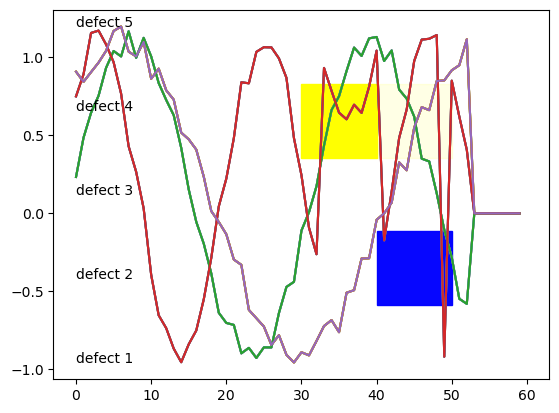

1/1 [==============================] - 0s 25ms/step
[False False False False  True]


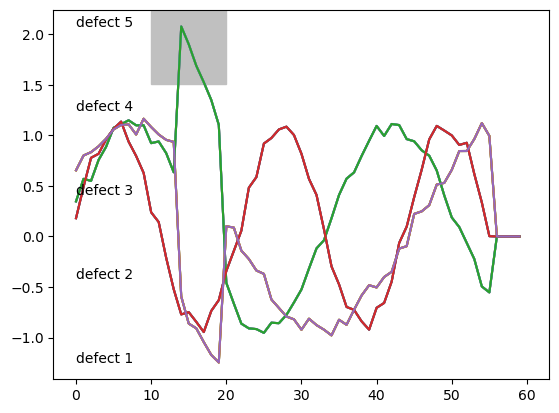

1/1 [==============================] - 0s 26ms/step
[False False  True False False]


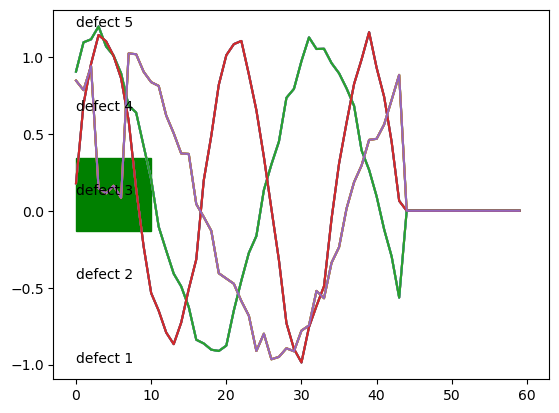

1/1 [==============================] - 0s 24ms/step
[False  True  True False False]


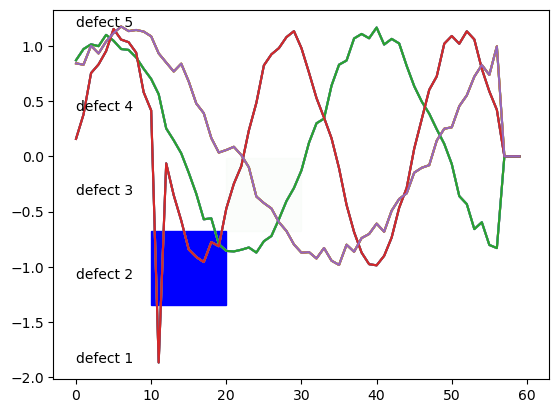

1/1 [==============================] - 0s 23ms/step
[ True False False False False]


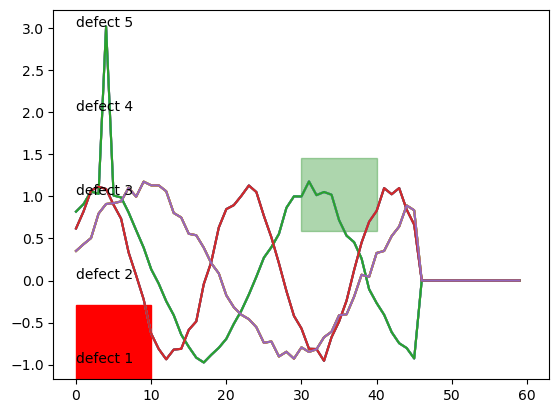

1/1 [==============================] - 0s 25ms/step
[ True False False False False]


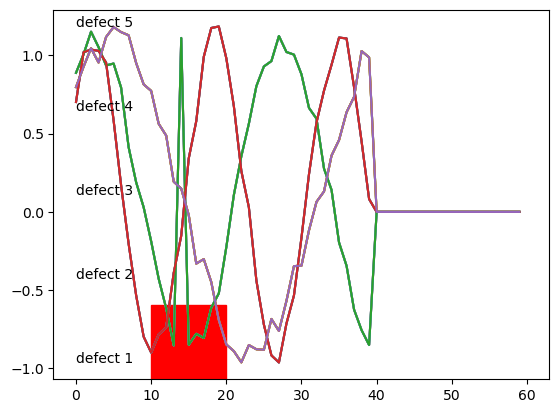

1/1 [==============================] - 0s 22ms/step
[False False False  True  True]


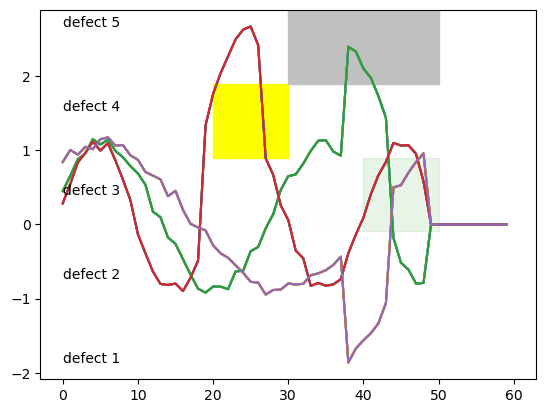

1/1 [==============================] - 0s 23ms/step
[False  True  True False False]


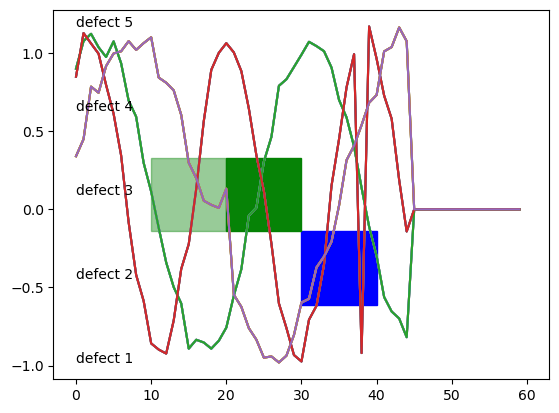

1/1 [==============================] - 0s 27ms/step
[ True False  True  True False]


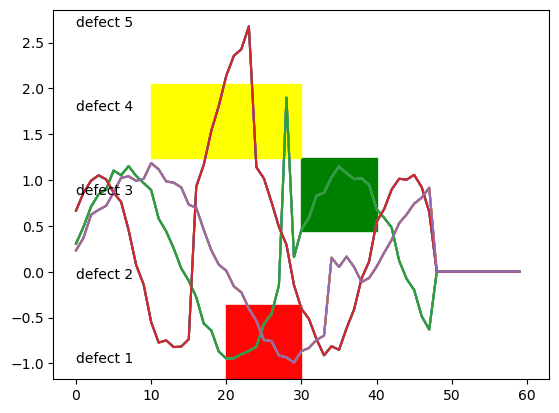

1/1 [==============================] - 0s 24ms/step
[False False False False  True]


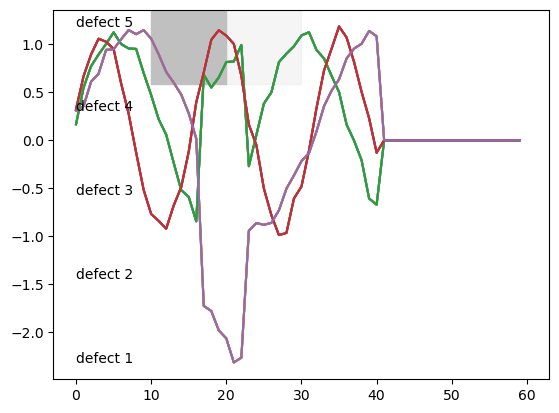

1/1 [==============================] - 0s 25ms/step
[False False False False  True]


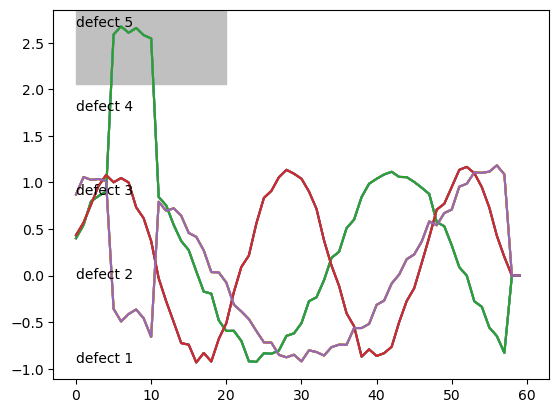

1/1 [==============================] - 0s 24ms/step
[ True False  True False  True]


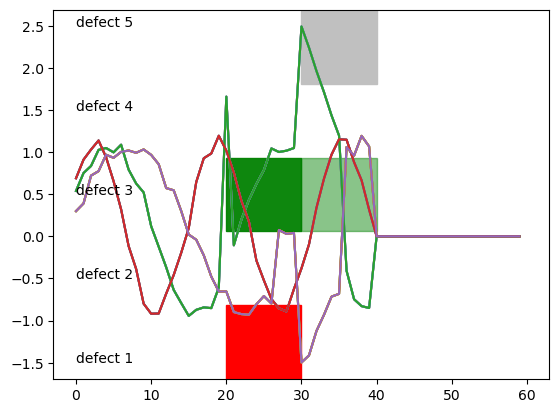

1/1 [==============================] - 0s 26ms/step
[False  True False False False]


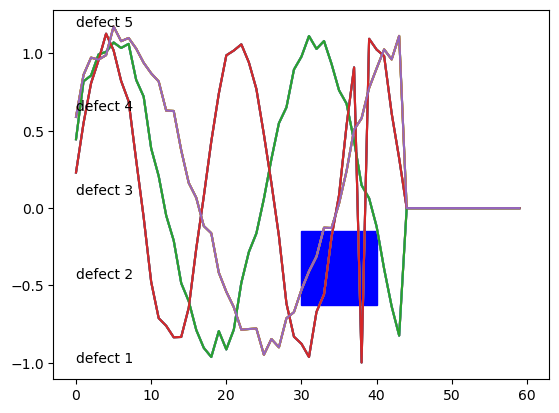

1/1 [==============================] - 0s 23ms/step
[ True False  True False False]


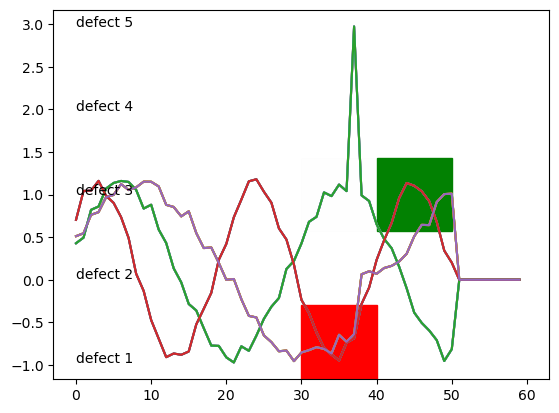

1/1 [==============================] - 0s 23ms/step
[False  True  True  True False]


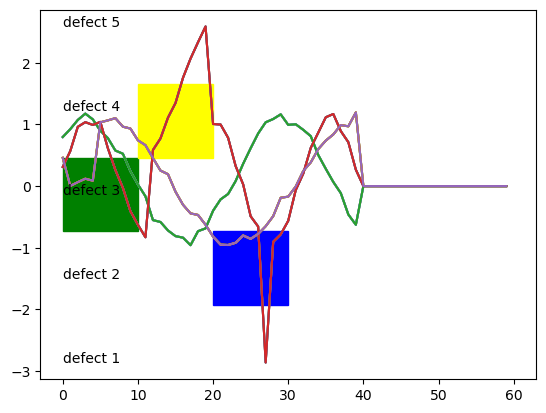

1/1 [==============================] - 0s 23ms/step
[False False False False False]


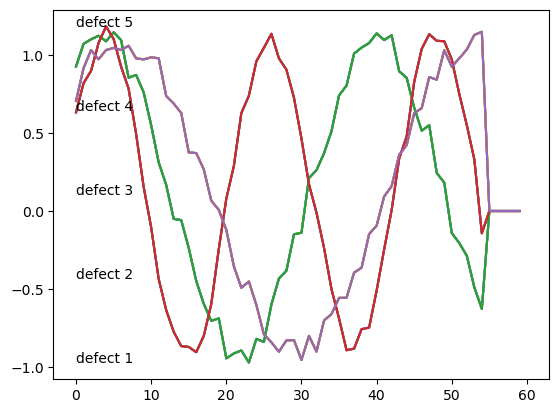

1/1 [==============================] - 0s 22ms/step
[ True False False  True False]


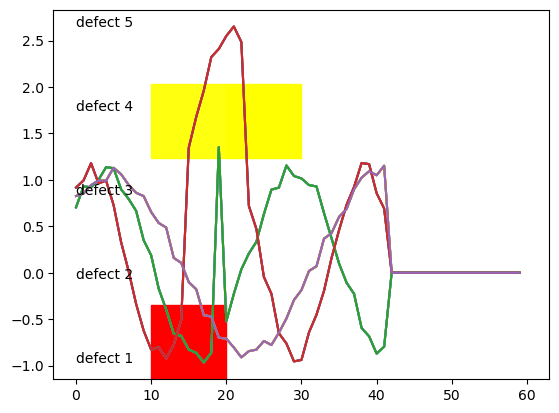

1/1 [==============================] - 0s 21ms/step
[False False False False  True]


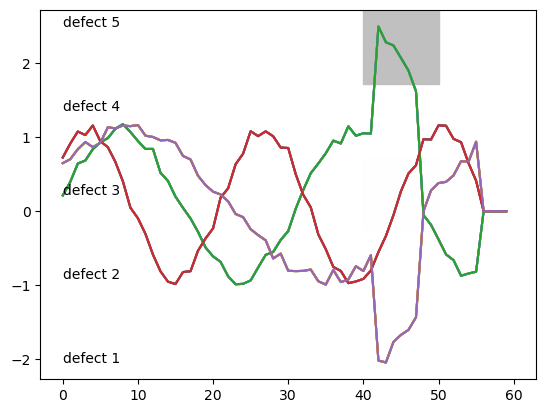

1/1 [==============================] - 0s 22ms/step
[False  True False False False]


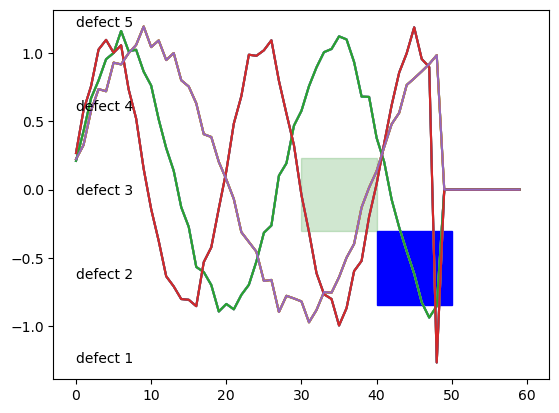

1/1 [==============================] - 0s 23ms/step
[ True False  True  True False]


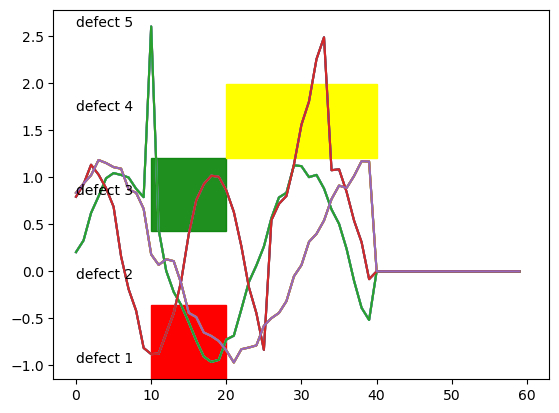

In [304]:
for k in np.random.randint(0, len(test_x), 20):
    example = test_x[k][None, ...]
    pred = model2.predict(example)
    print(test_y[k])
    positions_of_text = np.linspace(example.min(), example.max(), 5) 
    for z in [0, 1, 2, 3, 4]:
        colors = pred[0, ..., z]
        plt.plot(test_x[k])
        plt.text(0, positions_of_text[z], f"defect {z+1}")
        for i, q in enumerate(colors):
            plt.axvspan(i*10, i*10+10, ymin=z/5, ymax=(z+1)/5,
                        color={1: 'red', 2: 'blue', 3: 'green', 4: 'yellow', 5:'silver'}[z+1], alpha=q**2)
    plt.show()
    
